In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import itertools
from math import pi
import time
import matplotlib.pyplot as plt
import h5py
import orbithunter.persistent_homology as ohgudhi
import gudhi
score_type='persistence'
scoring_function = ohgudhi.gudhi_distance_from_persistence
persistence_function = ohgudhi.orbit_persistence

def critical_values(scores):
    cval = [0.0001, 0.001, 0.01, 0.05]
    return np.array([np.quantile(scores, q) for q in cval])


def produce_scores(family, bases, **kwargs):
    # Make it so group orbit must be passed, not calculated here. 
    family_scores = None
    print('[', end='')
    n = 0 
    n_samples = len(family)*len(bases)
    for window in family:
        print('#', end='')
        window = window.transform(to='field')
        for base in bases:
            scr = scan(base, window, **kwargs)[0].ravel()
            if family_scores is None:
                family_scores = np.zeros([n_samples, len(scr)])                             
            family_scores[n, :] = np.array(scr).ravel()
            n+=1
    print(']',end='')
    return family_scores.reshape(len(family), -1)

# Covering space-time with fundamental orbits.

This notebook produces statistics on the shadowing and covering of space-time by fundamental orbits.
The steps are as follows

    1. Produce a set of fundamental orbits whose combinations are believed to span all possible patterns
    2. Produce a (large) set of windows from trajectories
    3. Calculate the shadowing/covering metric between each window and each fundamental orbit (and group orbits)
    4. Using these distributions, determine a good absolute threshold for the computation of the various coverings.
    5. With each fundamental orbit and its group orbit (if statistics are the same, which they should be, approximately)
       compute the fraction of the large spacetime simulations that each group orbit covers. This can be done
       via either 
    
  

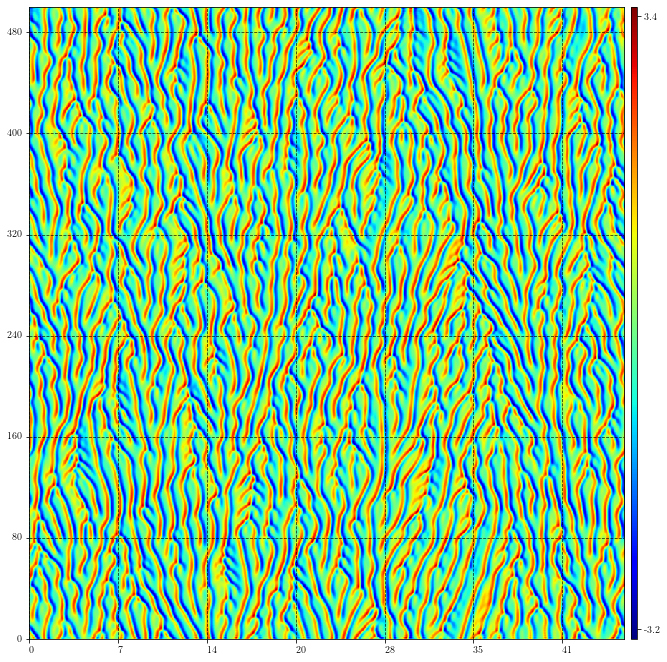

In [2]:
covering = [sorted([x.transform(to='field') for x in family], key=lambda o:o.x) for family in read_h5('continuation.h5')]
base = read_h5('large_patches.h5', '/1').resize(832, 832).transform(to='field')
base.plot()

# Shadowing

Before we can talk about the statistics and proportion of space-time that each orbit family covers,
we must first determine the baselines/threshold values for the shadowing metric. The most important
reason is simply to get a threshold value which is non-arbitary, based upon the distribution of this metric when
ranging over families, group orbits, and arbitrary trajectory segments in space-time. The second reason is to
delve into the details of the families themselves. As we shall see, not every orbit reached by numerical continuation is necessarily in the same continuous family. If accidentally mixed, then the thresholds as determined by the
distributions of the shadowing metric likely do not make sense. Persistent homology is used towards this end. It provides a guide for how to determine both the sampling and bounds of the members of each family to be used
as our covering set.

## Defect family investigation

Before jumping into the full problem, i.e. before using multiple continuous families, let us first investigate
a single family. To do so, we can import the previously derived family (produced via continuation).

In [3]:
defect_family = covering[0]
family_size = [len(x) for x in covering]

In [4]:
defect_family = sorted(covering[0], key=lambda x : x.t)
drifter_family = sorted(covering[1], key=lambda x : x.t)
large_defect_family = sorted(covering[2], key=lambda x : x.t)
wiggle_family = sorted(covering[3], key=lambda x : x.t)

In [36]:
L = []
T = []
for orbit in large_defect_family:
    L.append(orbit.x)
    T.append(orbit.t)

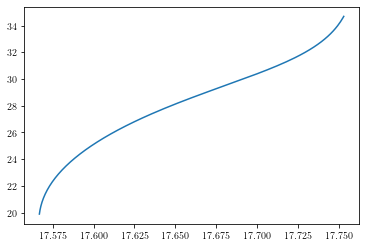

In [37]:
plt.plot(L,T)

One of the assumptions is that each orbit manifests on tiles of unique size. Therefore, the fact that multiple orbits
exist at the same spatial domain size destroys this; the only way this can be reconciled is if these actually pertain to different families. These branches can be pruned by putting at upper bound on the bottleneck distances between persistence
diagrams.

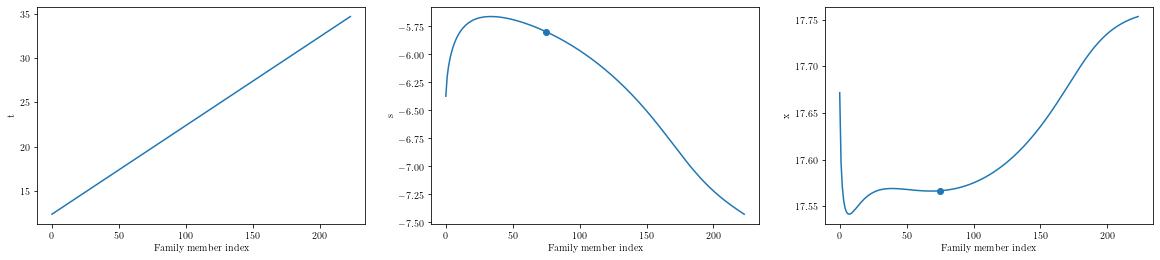

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot([x.t for x in large_defect_family])
ax2.plot([x.s for x in large_defect_family])
ax2.scatter([75], [large_defect_family[75].s])
ax3.plot([x.x for x in large_defect_family])
ax3.scatter([75], [large_defect_family[75].x])

ax1.set_xlabel('Family member index')
ax2.set_xlabel('Family member index')
ax3.set_xlabel('Family member index')

ax1.set_ylabel('t')
ax2.set_ylabel('s')
ax3.set_ylabel('x') 
plt.show()

In [6]:
all_persistences = []
for each_orbit in large_defect_family:
    all_persistences.append(ohgudhi.orbit_complex(each_orbit,
                                                 ).persistence(min_persistence=0.01))
entirety_homology_large_defect_scores = np.zeros([len(all_persistences),len(all_persistences)])
for i in range(len(all_persistences)):
    for j in range(i, len(all_persistences)):
        entirety_homology_large_defect_scores[i, j] = ohgudhi.gudhi_distance_from_persistence(all_persistences[i], 
                                                                                 all_persistences[j],
                                                                                 metric='bottleneck')
        
homology_large_defect_scores = entirety_homology_large_defect_scores.reshape(len(all_persistences),len(all_persistences))

In [7]:
print('The maximum bottleneck distance before pruning in {}'.format(homology_large_defect_scores.max()))

The maximum bottleneck distance before pruning in 0.832016311738579


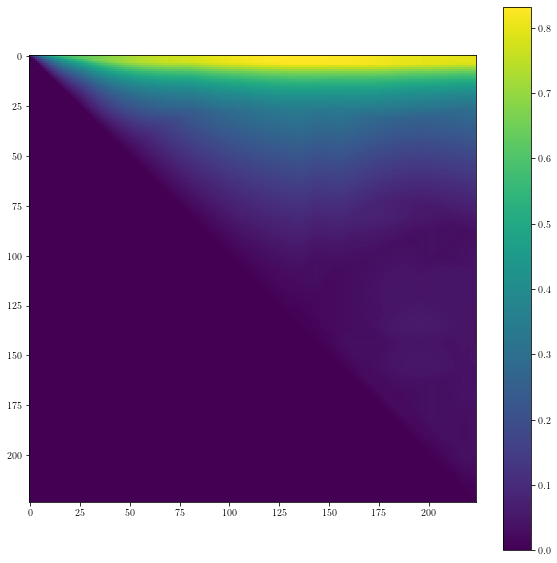

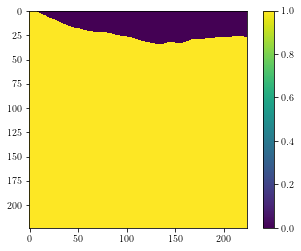

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(homology_large_defect_scores, interpolation='none')
plt.colorbar()
plt.show()

plt.imshow((entirety_homology_large_defect_scores < 0.3).astype(int), interpolation='none')
plt.colorbar()
plt.show()

In [9]:
all_persistences = []
for each_orbit in large_defect_family[75:]:
    all_persistences.append(ohgudhi.orbit_complex(each_orbit,
                                                 ).persistence(min_persistence=0.01))
entirety_homology_large_defect_pruned_scores = np.zeros([len(all_persistences),len(all_persistences)])
for i in range(len(all_persistences)):
    for j in range(i, len(all_persistences)):
        entirety_homology_large_defect_pruned_scores[i, j] = ohgudhi.gudhi_distance_from_persistence(all_persistences[i], 
                                                                                 all_persistences[j],
                                                                                 metric='bottleneck')
        
homology_large_defect_pruned_scores = entirety_homology_large_defect_pruned_scores.reshape(len(all_persistences),
                                                                                           len(all_persistences))

In [10]:
print('The maximum bottleneck distance after pruning in {}'.format(homology_large_defect_pruned_scores.max()))

The maximum bottleneck distance after pruning in 0.1165519334039089


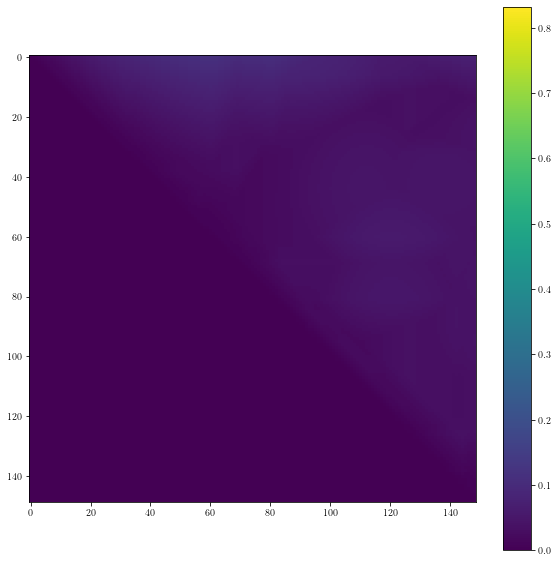

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(homology_large_defect_pruned_scores, interpolation='none', vmin=0., vmax=homology_large_defect_scores.max())
plt.colorbar()
plt.show()

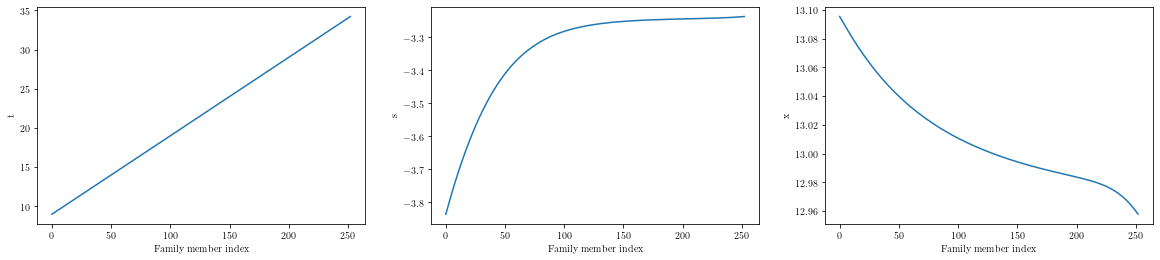

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot([x.t for x in defect_family[10:]])
ax2.plot([x.s for x in defect_family[10:]])
ax3.plot([x.x for x in defect_family[10:]])
ax1.set_xlabel('Family member index')
ax2.set_xlabel('Family member index')
ax3.set_xlabel('Family member index')
ax1.set_ylabel('t')
ax2.set_ylabel('s')
ax3.set_ylabel('x') 
plt.show()

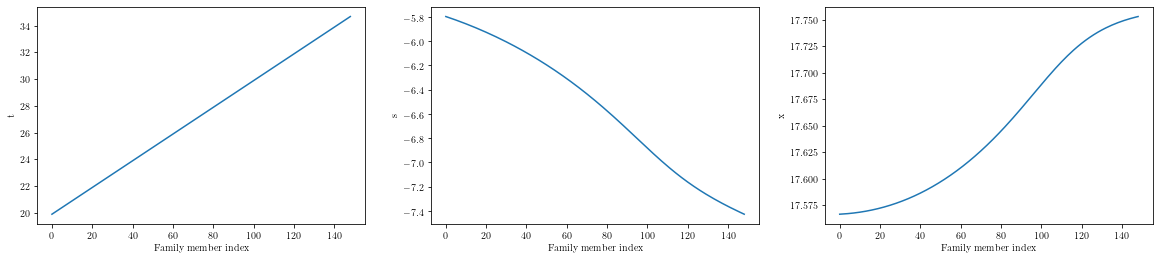

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot([x.t for x in large_defect_family[75:]])
ax2.plot([x.s for x in large_defect_family[75:]])
ax3.plot([x.x for x in large_defect_family[75:]])
ax1.set_xlabel('Family member index')
ax2.set_xlabel('Family member index')
ax3.set_xlabel('Family member index')
ax1.set_ylabel('t')
ax2.set_ylabel('s')
ax3.set_ylabel('x') 
plt.show()

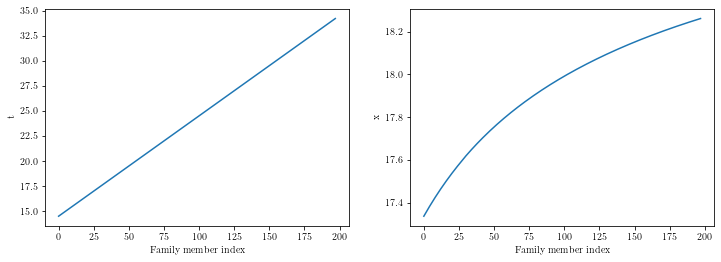

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot([x.t for x in wiggle_family[65:]])
ax2.plot([x.x for x in wiggle_family[65:]])
ax1.set_xlabel('Family member index')
ax2.set_xlabel('Family member index')
ax1.set_ylabel('t')
ax2.set_ylabel('x') 
plt.show()

In [15]:
defect_family = sorted(covering[0], key=lambda x : x.t)[10:]
drifter_family = sorted(covering[1], key=lambda x : x.t)
large_defect_family = sorted(covering[2], key=lambda x : x.t)[75:]
wiggle_family = sorted(covering[3], key=lambda x : x.t)[65:]

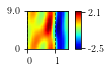

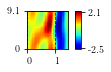

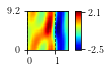

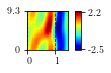

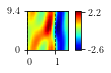

In [16]:
for y in defect_family[:5]:
    y.plot()

In [17]:
covering_families = [defect_family, drifter_family, large_defect_family, wiggle_family]
entire_covering = [o for fam in covering_families for o in fam]

First, a quick glimpse through example orbits reached by continuation. 

### Methodology

To collect our distribution of the amplitude difference metric, there are three choices to be made.

    1. The base orbits to scan over
    2. How often to sample them (i.e. how many window positions to compute the amplitude difference).
    3. How many group orbit members to use for each window orbit.
    
For the preliminary investigations, thirty different trajectory segments produced by integration are used, each of which has large spatiotemporal area. To reduce their relations to one another, the trajectory segments are part of a very long trajectory which has been chopped into pieces. Every other piece is collected to be used as a base orbit. Clearly if regions of space-time can be strongly correlated when separated by 500 dimensionless time units, this breaks down.

Instead of exhaustively computing the statistic; for every position for each group orbit member in each family, the
sampling is done by taking a subset of the group orbit members and a subset of the positions; for each member of the
continuous family defined in ```defect_family```
    
Additionally, the windows are rediscretized to abide by the same grid spacing as the base orbit as clearly
shadowings are assumed to be the same size as the orbits they shadow. 

In [18]:
sampling_rate = 1
bases_labels = [str(int(base_num*sampling_rate))for base_num in range(1000//sampling_rate)]
bases = [y for y in  read_h5('small_patches.h5', tuple(bases_labels))]

To compute the amplitude differences, iterate over the windows (family members), each window's group orbit (taken to be discrete subgroup for this run, and the 30 base orbits (trajectories). 

#### Group orbit distribution of amplitude difference $|u^2 - v^2|$ metric

In [19]:
kwargs = {          
          'strides': (64, 64),
          'fundamental_domain': False,
          'group_orbit': False,
          'n_trajectories':1000,
          'sampling_rate':10
           }

defect_family_scores = produce_scores([x for x in defect_family[::5]], bases[::2], **kwargs)

[###################################################]

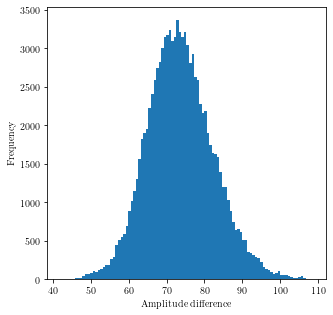

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.hist(defect_family_scores.ravel(), bins=100)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amplitude difference')
plt.show()

The distribution for each family member (all group orbit members included) can be overlaid on top of one another to approximate whether the variables can be treated as IID or not. 



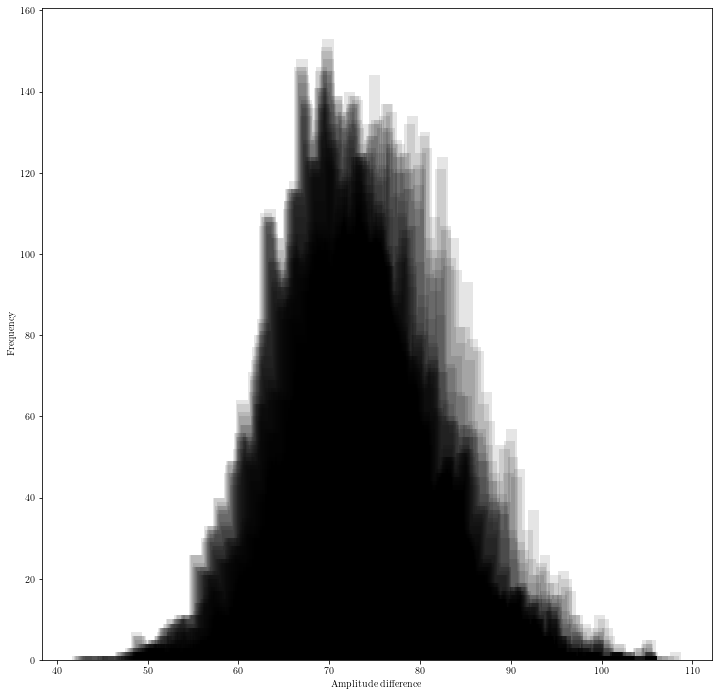

In [21]:
plt.figure(figsize=(12,12))
for g in defect_family_scores.reshape(len(defect_family[::5]), -1):
    plt.hist(g.ravel(), alpha=0.1, color='black', bins=50)
plt.ylabel('Frequency')
plt.xlabel('Amplitude difference')
plt.show()

In [22]:
kwargs = {          
          'strides': (64, 64),
          'fundamental_domain': False,
          'n_trajectories':1000,
          'sampling_rate':10
           }
group_orbit = tuple(defect_family[-200].group_orbit(rolls=(8,8)))
defect_group_orbit_scores = produce_scores(group_orbit, bases[::2], **kwargs)

[################################]

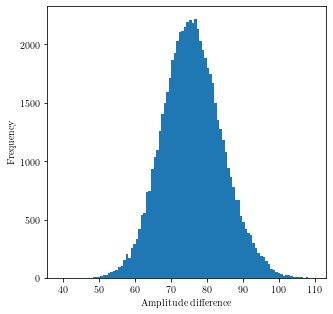

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.hist(defect_group_orbit_scores.ravel(), bins=100)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amplitude difference')
plt.show()

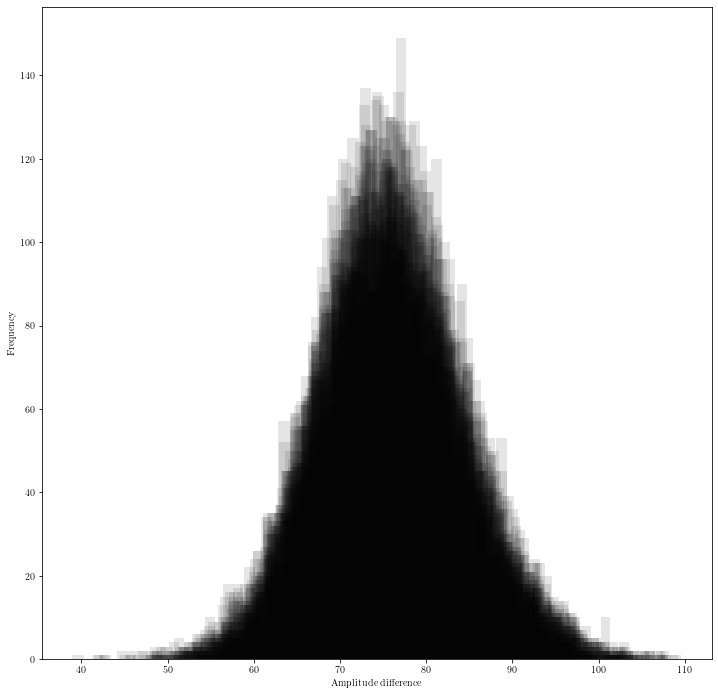

In [24]:
plt.figure(figsize=(12,12))
for g in defect_group_orbit_scores.reshape(len(tuple(defect_family[-200].group_orbit(rolls=(8,8)))),-1):
    plt.hist(g.ravel(), alpha=0.1, color='black', bins=50)
plt.ylabel('Frequency')
plt.xlabel('Amplitude difference')
plt.show()

Because we want thresholds for each family, it does not make sense to me to use a single threshold value if each
member has a different distribution. To determine the bounds of each family, I appeal to persistent homology;
specifically, the "bottleneck distance" between the family members. This is made accessible through the ```gudhi``` package, which I have built in some wrappers for.

In [25]:
import orbithunter.persistent_homology as ohgudhi

Take the pairwise bottleneck distance between each family member and plot as as a symmetric matrix

#### Family partitionion based on persistent homology.

To really hammer the point home: even though we basically know how to split orbits up into families, based on the original continuation, compute ALL pointwise bottleneck distances.

comoving

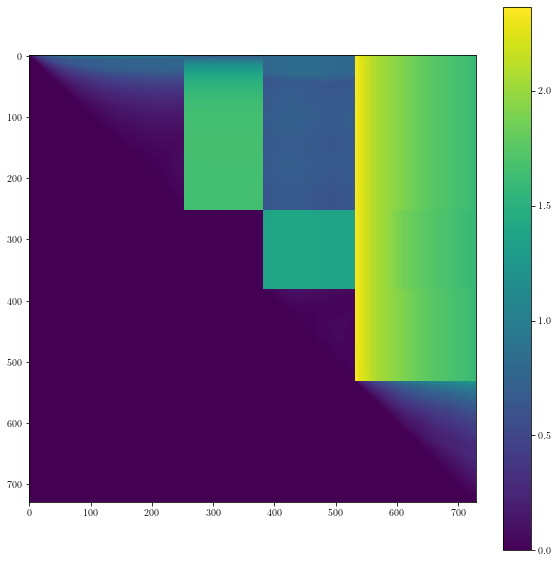

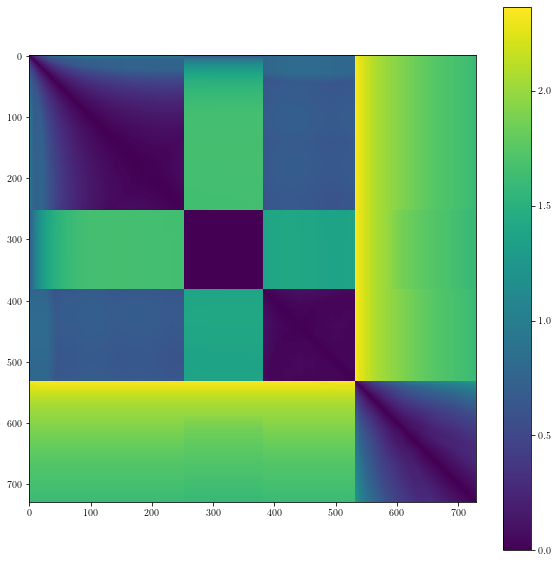

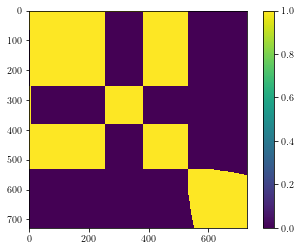

In [26]:
all_persistences = []
for each_orbit in entire_covering:
    all_persistences.append(ohgudhi.orbit_complex(each_orbit,
                                                 ).persistence(min_persistence=0.01))
entirety_homology_scores = np.zeros([len(all_persistences),len(all_persistences)])
for i in range(len(all_persistences)):
    for j in range(i, len(all_persistences)):
        entirety_homology_scores[i, j] = ohgudhi.gudhi_distance_from_persistence(all_persistences[i], 
                                                                                 all_persistences[j],
                                                                                 metric='bottleneck')
        
homology_scores = entirety_homology_scores.reshape(len(all_persistences),len(all_persistences))

plt.figure(figsize=(10,10))
plt.imshow(homology_scores, interpolation='none')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow((entirety_homology_scores+entirety_homology_scores.T), interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(((entirety_homology_scores+entirety_homology_scores.T) < 0.9).astype(int), interpolation='none')
plt.colorbar()
plt.show()

Why is there coupling (the checkerboard pattern) instead of a block diagonal structure? (this is an arbitrary threshold mind you). It turns out that the first three "families"
are likely connected. The checkerboard pattern simply emerges from their arrangement. To provide evidence for this we can look at the 'families' members directly. For example. The first 5 or so members of the first family seem coupled to the second family.

(9.500844832189543, 13.08825999116121)


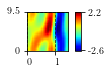

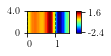

(9.60084483218954, 13.08686839871315)


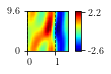

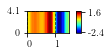

(9.700844832189539, 13.08548962854317)


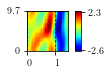

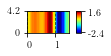

(9.800844832189537, 13.08412431167504)


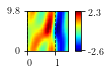

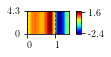

(9.900844832189534, 13.082772972361548)


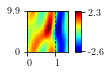

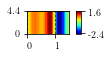

In [27]:
for x,y  in zip(defect_family[5:], drifter_family[:5]):
    print(x.dimensions())
    x.plot(), y.plot()

Likewise, there seeems to be strong similarity between the first and third families; they are essentially the same orbit but on different domain sizes. The connection between these two branches is elusive; hence the segmentation.

(32.31084483219184, 12.973721398833037)


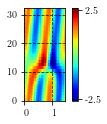

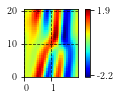

(31.310844832191798, 12.978045930356435)


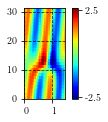

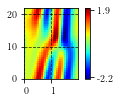

(30.31084483219164, 12.980951030532486)


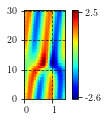

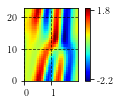

In [28]:
for x,y  in zip(np.array(defect_family)[[-20, -30, -40]], np.array(large_defect_family)[[10, 20, 30]]):
    print(x.dimensions())
    x.plot(), y.plot()

Combining these three branch segments and then ordering by temporal periods yields the following bottleneck distance matrix

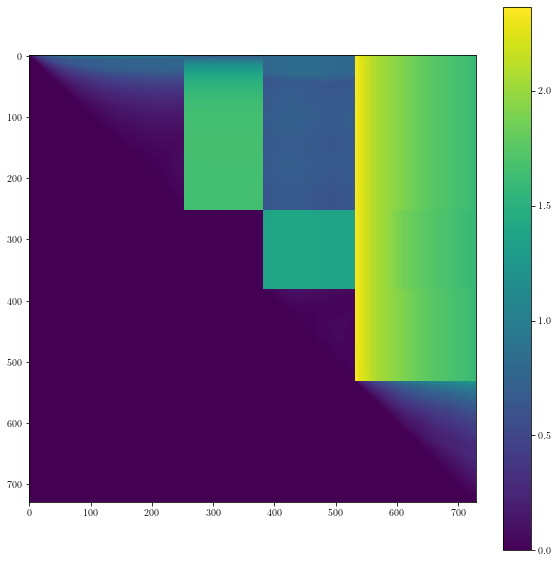

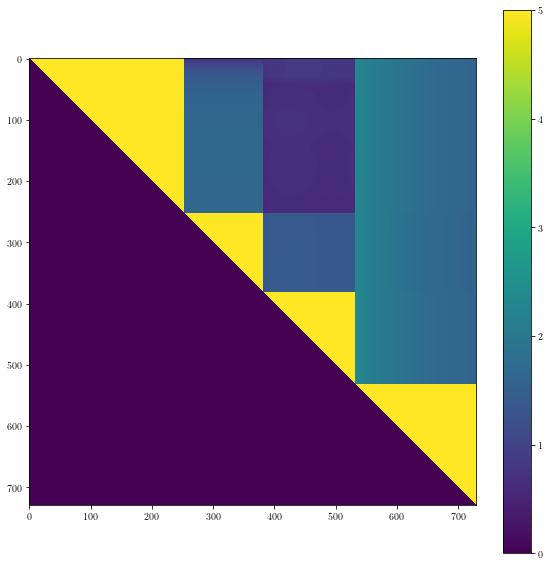

In [29]:
truth_values = homology_scores.copy()
plt.figure(figsize=(10,10))
plt.imshow(homology_scores, interpolation='none')
plt.colorbar()
plt.show()

for slc in [slice(0,253), slice(253, 382), slice(382, 531), slice(531,None)]:
    truth_values[slc, slc] = 5
truth_values=truth_values.T
truth_values[np.triu_indices(truth_values.shape[0], k=0)]=0
truth_values=truth_values.T

plt.figure(figsize=(10,10))
plt.imshow(truth_values, interpolation='none')
plt.colorbar()
plt.show()

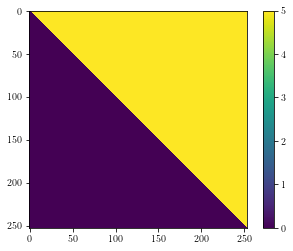

################################################


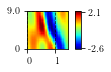

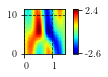

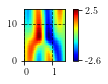

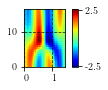

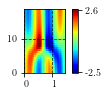

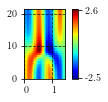

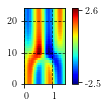

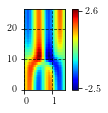

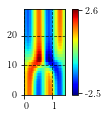

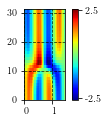

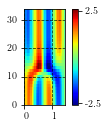

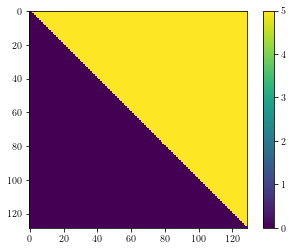

################################################


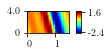

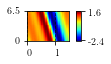

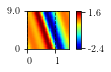

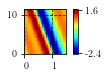

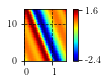

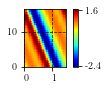

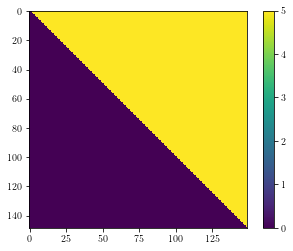

################################################


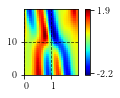

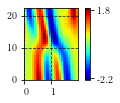

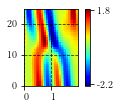

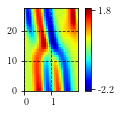

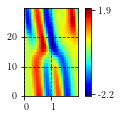

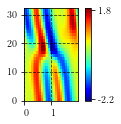

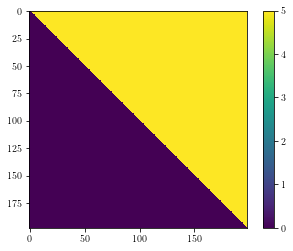

################################################


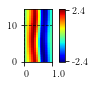

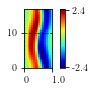

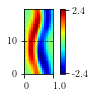

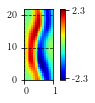

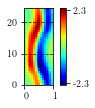

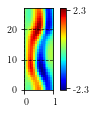

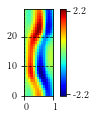

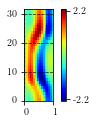

In [30]:
for slc in [slice(0,253), slice(253, 382), slice(382, 531), slice(531,None)]:
    plt.figure()
    plt.imshow(truth_values.astype(int)[slc, slc], interpolation='none')
    plt.colorbar()
    plt.show()
    print('################################################')
    for orbit in entire_covering[slc][::25]:
        orbit.to_fundamental_domain().plot(padding=False)

In [31]:
covering_processed = []
for slc in [slice(0,253), slice(253, 382), slice(382, 531), slice(531,None)]:
    covering_processed.append(entire_covering[slc])
large_covering = [np.array(x) for x in covering_processed]

###
(14.30084483218944, 13.03759136983164, -3.398712699303085)


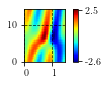

###
(14.419717642897997, 13.174810274046457, -6.732012555306101)


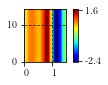

###
(22.390629775248556, 17.57516682770209, -5.965036160383544)


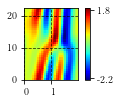

###
(15.000880409356625, 17.39252506361242, 0.0)


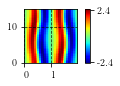

In [32]:
# for slicing purposes
large_covering = [np.array(x) for x in covering_processed]

medium_covering =[np.array(large_covering[0])[100::25],
                                           np.array(large_covering[1])[::25],
                                           np.array(large_covering[2])[:-50:25],
                                           np.array(large_covering[3])[::25]]

small_covering = [np.array(large_covering[0])[100::50],
                                           np.array(large_covering[1])[::50],
                                           np.array(large_covering[2])[:-50:50],
                                           np.array(large_covering[3])[::50]]

minimal_covering = [np.array(large_covering[0])[[-200]],
         np.array(large_covering[1])[[-25]],
         np.array(large_covering[2])[[25]],
         np.array(large_covering[3])[[5]]]

for x in minimal_covering:
    print('###')
    for y in x:
        print(y.parameters)
        y.plot()

In [33]:
keys = tuple(['defect', 'drifter', 'larger_defect', 'wiggle'])

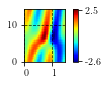

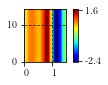

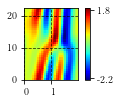

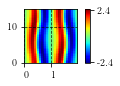

In [34]:
for x in np.concatenate(minimal_covering):
    x.plot()

In [35]:
# for name, families in zip(keys, covering_processed):
#     for orbit in families:
#         orbit.to_h5('large_cover.h5', groupname=name, verbose=True)

# for name, families in zip(keys, medium_covering):
#     for orbit in families:
#         orbit.to_h5('medium_cover.h5', groupname=name, verbose=True)

# for name, families in zip(keys, small_covering):
#     for orbit in families:
#         orbit.to_h5('small_cover.h5', groupname=name, verbose=True)

# for name, families in zip(keys, minimal_covering):
#     for orbit in families:
#         orbit.to_h5('minimal_cover.h5', groupname=name, verbose=True)